To understand implementation of Fast Fourier Transform (FFT) on DSP. The following tasks will be carried out here,

*   Compute DFT and FFT for a fixed length sequence
*   Compare the performances of FFT and DFT with the help of profiling.

# Discrete Fourier Transform (DFT).

The concept of Discrete Fourier Transform (DFT) was introduced to allow us to work with the frequency domain representation of discrete-time signals while staying in discrete (frequency) domain. The following equation gives the expression for the DFT calculation of a sequence $x[n]$.
<br>
<br>

$X[k] = \sum_{n=0}^{N-1} x[n] W_{N}^{kn},\hspace{1in} k=0,1,\dots,N-1\
$ <br><br>
Here, $x[n]$ is the input sequence of length N, $X[k]$ is the N-point DFT of x[n] and $W_N$ = $e^{-j\frac{2\pi}{N}}$.

<br>
In general, to calculate the DFT by this algorithm, the computations (in terms of complex multiplications and additions) required vary with $N$ as $O(N^2)$. So, as $N$ grow higher, the number of computations grows at a higher rate and FFT calculation operation begins to act as a bottleneck for the system. This extremely high number of computations required in the naive implementation of DFT was a major obstacle in its acceptance.

Fast Fourier Transform

 An efficient algorithm to calculate the DFT was proposed by J. W. Cooley and J. W. Tuckey in the year 1965. At first, they themselves did not realize the importance of the algorithm they proposed. But, the algorithm was widely accepted and it was termed as the $\textbf{Fast Fourier transform}$. The algorithm uses the $\textit{divide and conquer}$ technique to calculate DFT of sequences of very large length. It splits a higher order DFT calculation into several lower order ones and then these lower order DFTs into further lower order ones until this cannot be continued. Now, it can be proved that the number of computations required to calculate a higher order DFT directly is very high as compared to splitting the DFT into lower order DFTs, calculating them and combining the results in appropriate manner to get the initial higher order DFT. This brings the order of computations required to calculate an $N$ point DFT from $O(N^2)$ to $O(Nlog_2(N))$ which is a substantial improvement. You are going to study the implementation of FFT on the DSP in this lab session.
  
A radix-2 decimation-in-time (DIT) FFT is the simplest form of the Cooley–Tukey algorithm. Radix-2 DIT divides a DFT of size N into two interleaved DFTs (hence the name `radix-2') of size N/2 with each recursive stage. The full radix-2 Decimation in time FFT decomposition is illustrated in figure below using the simplified butterfly structure.


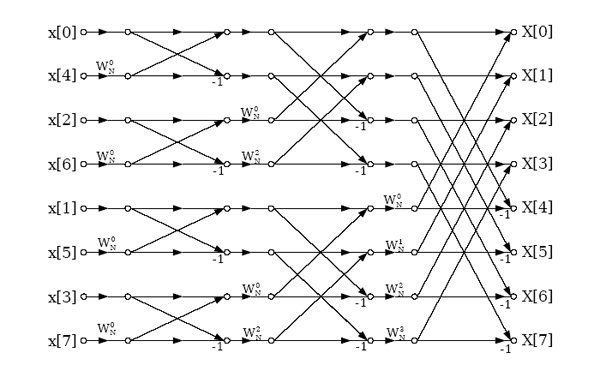

[FFT Image reference](https://www.versci.com/fft/index.html)

---
The following sections consist of the codes needed for this lab. Write your code in the blocks as per the instructions.

## Importing Libraries

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal

## Utility Functions

1. signal_generation() - This function will generate n_samples of sinusoid of given frequency sampled at given sampling rate Fs

2. plot_transform() - This function will plot the signal and its magnitude transform. Note that you have to calculate the magnitude of the fourier trasnform and give to this function

In [ ]:
def signal_generation(n_samples=100, freq=1, sampling_rate=100, amplitude=1, phase=0, zero_pad=0):
  """Sinusoid of frequency 'freq' sampled at 'sampling_rate'. This function
  will return 'n_samples' samples of the signal

  Args:
    n_samples: Number of samples of the singal to be returned
    freq: Frequency of the sinusoid (in Hz)
    sampling_rate: Sampling rate of the sinusoid
    amplitude: Amplitude of the generated signal
    zero_pad: number of zeros to add on both sides of the signal
  """
  t = np.arange(n_samples) / sampling_rate
  x = amplitude * np.sin(2 * np.pi * (freq*t - phase))
  x = np.pad(x, (zero_pad, zero_pad), 'constant', constant_values=(0, 0))
  return x, t


def ft_shift(ft):
  N = ft.shape[0]
  ft = np.roll(ft, N//2)
  return ft


def plot_transform(x, t, magnitude, sampling_rate, zero_pad=0):
  """Plot the signal, magnitude response of it's Fourier Transform
  Args:
    x: singal
    t: samples in time
    magnitude: magnitude of the fourier transform
    sampling_rate: sampling rate of the signal
    zero_pad: zero_pad factor given in signal_generation function
  """
  plt.rcParams["figure.figsize"] = (20,8)
  N = x.shape[0]
  if zero_pad:
    x = x[zero_pad:-1*zero_pad]

  # signal plot
  plt.subplot(211)
  plt.plot(t, x)
  plt.grid()
  plt.xlabel('Time (seconds)')
  plt.ylabel('Amplitude')

  # Magnitude Plot
  plt.subplot(212)
  x_mag = sampling_rate * (np.arange(N)/N - 0.5)
  plt.stem(x_mag, ft_shift(magnitude))
  plt.grid()
  plt.xlabel('Freq (Hz)')
  plt.ylabel('Magnitude response ($|X|$)')

  plt.show()

## DFT Checkpoints

### Checkpoint 1


The formula for DFT is

$X[k] = \sum_{n=0}^{N-1} x[n] W_{N}^{kn},\hspace{1in} k=0,1,\dots,N-1\
$ <br><br>
Here, $x[n]$ is the input sequence of length N, $X[k]$ is the N-point DFT of x[n] and $W_N$ = $e^{-j\frac{2\pi}{N}}$.

In [ ]:
# DFT Solution

def dft(x):
    n = len(x)
    y_dft = [0 + 1j*0]*n
    for k in range(n):
        real = 0
        imag = 0
        for t in range(n):
            angle = 2 * np.pi * t * k / n
            real += (x[t].real*math.cos(angle)) + (x[t].imag*math.sin(angle))
            imag += (-1*x[t].real*math.sin(angle)) + (x[t].imag*math.cos(angle))
        y_dft[k] = real + 1j*imag
    return np.array(y_dft)

### Checkpoint 2

Working of this testbench :     

The testbench does two things, calculate_error() function calculates dft using your function, as well as the numpy's fft function. If both the outputs lie in a specific tolerance band i.e. have error less than a particular threshold, then the dft() function has passed the specific test case.

The other function, check_waveforms() function, takes the different waveforms generated and using the calculate_errors() function, checks the error for each waveform.

In [ ]:
def calculate_errors(input_signal, func):
	dft_out = func(input_signal)
	np_out = np.fft.fft(input_signal)
	error = np.sum(np.abs(dft_out - np_out))
	if error<1e-2:
		return True, dft_out, np_out
	else:
		return False, dft_out, np_out


def check_waveforms(waveforms, func):
	for wave_fn, args, name in waveforms:
		input_signal = wave_fn(**args)
		result, dft_out, np_out = calculate_errors(input_signal, func)
		if result==False:
			print(f"Incorrect result for {name}. Please check your code")
			print("Your output:", dft_out)
			print("Expected output:", np_out, "\n")
		else:
			print(f"Test: {name} PASSED\n")

t = np.linspace(0, 1, 32)

waveforms = [(signal.chirp, {"t":t, "f0":70, "t1":0.95, "f1":140}, "chirp"),	# chirp
	         (signal.sawtooth, {"t":2*np.pi*5*t, "width":1}, "sawtooth"),			# sawtooth
	         (signal.sawtooth, {"t":2*np.pi*5*t, "width":0.5}, "triangular"),	# triangular
	         (signal.square, {"t":2*np.pi*5*t, "duty":0.5}, "square")]			# square wave

In [ ]:
check_waveforms(waveforms, dft)

Test: chirp PASSED

Test: sawtooth PASSED

Test: triangular PASSED

Test: square PASSED



### Checkpoint 3

Magnitude plot of DFT of following 3 sinusoids is plooted at a sampling rate fixed at 128 Hz.
1. Freq = 20Hz, Window Length = 64 samples, DFT length = 64 samples
2. Freq = 19Hz, Window Length = 64 samples, DFT length = 64 samples
3. Freq = 20Hz, Window Length = 64 samples, DFT length = 128 samples

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


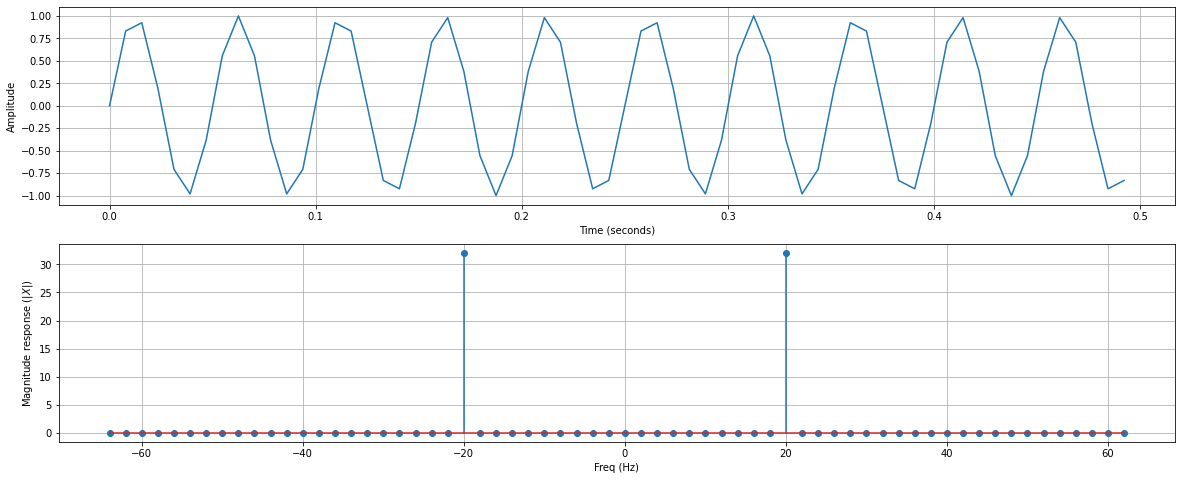

In [ ]:
# Freq = 20Hz, n_samples = 64

Fs = 128

x, t = signal_generation(64, 20, Fs, 1)
ft = dft(x)
mag = np.abs(ft)
plot_transform(x, t, mag, Fs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


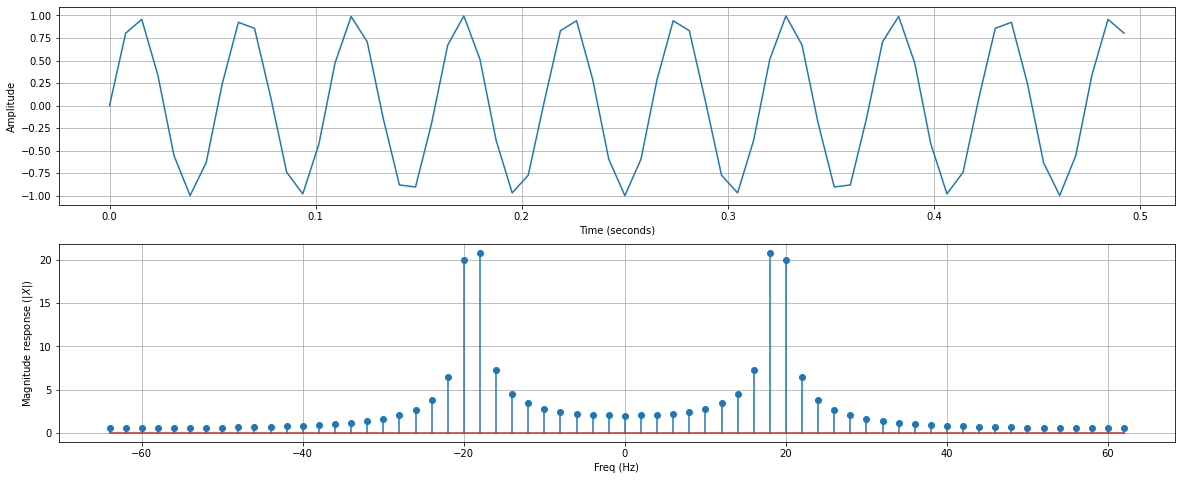

In [ ]:
# Freq = 19Hz, n_samples = 64

x, t = signal_generation(64, 19, Fs, 1)
ft = dft(x)
mag = np.abs(ft)
plot_transform(x, t, mag, Fs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


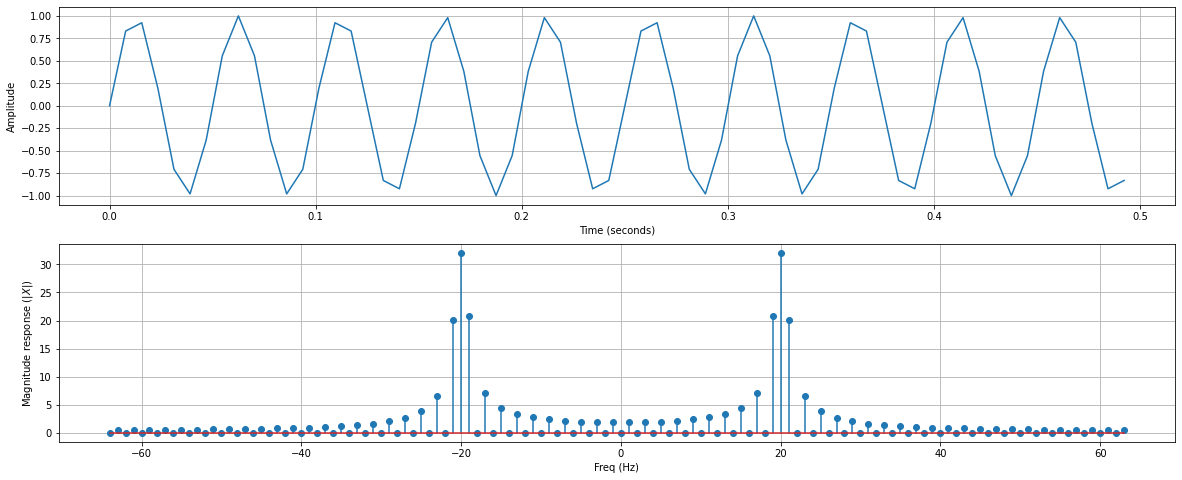

In [ ]:
# Freq = 20Hz, n_samples = 64, zero_pad = 32

x, t = signal_generation(64, 20, Fs, 1, zero_pad=32)
ft = dft(x)
mag = np.abs(ft)
plot_transform(x, t, mag, Fs, 32)

## FFT Checkpoints

Now that you have implemented the DFT code, its time to implement the FFT version of the same, we will do this for N = 8 points. The description for various code blocks will be written in the subsequent sections itself.

**FFT for N = 8 points**
 The first function, bitrev() is used to reverse the order of array $x$. For example, 001 on bit reversal becomes 100, 011 becomes 110 and so on, hence $x[0],x[1],x[2],x[3],...$ will become $x[0],x[4],x[2],x[6],...$ to get the order as mentioned in the [FFT section](#scrollTo=puKfGAmmL9QA)

The next function is complex_multiply() which, as the name indicates, multiplies two complex numbers. Finally, the butterfly() finds the 2-point DFT.

In [ ]:
#Bit reversal function
def bitrev(x):
    """Funtion for bit reversal
    Note that you are working with 8 point fft
    So you only need 3 bits to be reversed
    """
    units_place_bit = x%2
    tens_place_bit = (x>>1)%2
    hund_place_bit = (x>>2)%2
    return (4*units_place_bit) + (2*tens_place_bit) + hund_place_bit

#Multiplication of complex numbers
def complex_multiply(x0, x1):
    """Complex multiplication of 2 complex numbers
    Calculate the real and imag part separately and return
    the complex number
    """
    real = (x0.real*x1.real) - (x0.imag*x1.imag)
    imag = (x0.real*x1.imag) + (x0.imag*x1.real)
    return real + 1j*imag

#Butterfly structure for 2 point FFT
def butterfly(x0, x1):
    """Butterflu operation
    Takes in 2 numbers x0 and x1 and returns 2 values y0 and y1
    """
    y0_real = x0.real + x1.real
    y0_imag = x0.imag + x1.imag
    y1_real = x0.real - x1.real
    y1_imag = x0.imag - x1.imag
    y0 = y0_real + 1j*y0_imag
    y1 = y1_real + 1j*y1_imag
    return y0, y1

In [ ]:
#FFT

def fft(x):
    y_fft = np.array([0 + 1j*0]*8)
    twiddle_real = np.array([1,0.7071,0,-0.7071])  # twiddle_real[k]=cos((2pi/8)*k) ; 0<=k<=4
    twiddle_imag = np.array([0,-0.7071,-1,-0.7071])  # twiddle_imag[k]=-sin((2pi/8)*k); 0<=k<=4
    twiddle = twiddle_real + 1j*twiddle_imag
    x_bitrev = [0]*8
    stage1 = [0]*8
    stage2 = [0]*8

    # Calculation the bit-reversed form of x in x_bitrev.
    for i in range(8):
        x_bitrev[i] = x[bitrev(i)] + 1j*0

    # Calculation of the stage 1 values with the help of butterfly() function.
    # You can omit the "multiplication by twiddle factor" stage here as all of them are 1.
    for i in range(4):
        y0, y1 = butterfly(x_bitrev[2*i], x_bitrev[2*i + 1])
        stage1[2*i] = y0
        stage1[(2*i) + 1] = y1

    # Calculation of the stage 2 values from stage 1 values with the help of complex_multiply() and butterfly() functions
    for i1 in range(2):
        for i2 in range(2):
            # Multiply selected values in stage 1 by the twiddle factors before calculating the butterfly.
            temp = complex_multiply(stage1[(4*i1) + i2 + 2], twiddle[2*i2])
            stage1[(4*i1) + i2 + 2] = temp
            # Butterfly calculation
            y0, y1 = butterfly(stage1[(4*i1) + i2], stage1[(4*i1) + i2 + 2])
            stage2[(4*i1)+i2] = y0
            stage2[(4*i1)+i2+2] = y1

    # Calculation of the output values from stage 2 values with the help of complex_multiply() and butterfly() functions.
    for i in range(4):
        # Multiply selected values in stage 2 by the twiddle factors appropriately before calculating the butterfly.
        stage2[i+4] = complex_multiply(stage2[i+4], twiddle[i])
        # Butterfly calculation
        yi, yip4 = butterfly(stage2[i], stage2[i+4])
        y_fft[i] = yi
        y_fft[i+4] = yip4

    return y_fft

### Checkpoint 2
**Error check in the code using the following test cases**


In [ ]:
from scipy import signal

def calculate_errors_fft(input_signal):
	dft_out = fft(input_signal)
	np_out = np.fft.fft(input_signal)
	error = np.sum(np.abs(dft_out - np_out))
	if error<1e-2:
		return True, dft_out, np_out
	else:
		return False, dft_out, np_out


def check_waveforms_fft(waveforms):
	for wave_fn, args, name in waveforms:
		input_signal = wave_fn(**args)
		result, dft_out, np_out = calculate_errors_fft(input_signal)
		if result==False:
			print(f"Incorrect result for {name}. Please check your code")
			print("Your output:", dft_out)
			print("Expected output:", np_out, "\n")
		else:
			print(f"Test: {name} PASSED\n")

t = np.linspace(0, 1, 8)

waveforms = [(signal.chirp, {"t":t, "f0":70, "t1":0.95, "f1":140}, "chirp"),	# chirp
	         (signal.sawtooth, {"t":2*np.pi*5*t, "width":1}, "sawtooth"),			# sawtooth
	         (signal.sawtooth, {"t":2*np.pi*5*t, "width":0.5}, "triangular"),	# triangular
	         (signal.square, {"t":2*np.pi*5*t, "duty":0.5}, "square")]			# square wave

 Your function is good to go if it passes all the test cases.

In [ ]:
check_waveforms_fft(waveforms)

## Profiler

For all fixed parameters, the function that takes the least time to run, is said to be optimized. This task can be done using Cprofile package and its results can be visualized using gprof2dot package.

In [ ]:
!pip install gprof2dot

  Created wheel for gprof2dot: filename=gprof2dot-2021.2.21-py3-none-any.whl size=27761 sha256=5259f7df6d696baca0e8d3f5939358fd7e83188cde52bd450c897f2737ebaa28
  Stored in directory: /root/.cache/pip/wheels/70/ff/20/2eafd73841d3a2cb7a920cecd29cb5edbe460037ac17c1ae96
Successfully built gprof2dot


In [ ]:
import gprof2dot
import cProfile as profile

We will generate the .pstat file which will be used for the visualization. Below is the code for generating the .pstat file.

In [ ]:
input_signal = [1,1,2,2,3,3,4,4]
input_signal = [i + 1j*0 for i in input_signal]
runs = 50000
profile_result_file = 'dft_fft_profile_small.pstat'

pr = profile.Profile()
pr.enable()
for _ in range(runs):
	dft_out = dft(input_signal)
	fft_out = fft(input_signal)
	np_fft = np.fft.fft(input_signal)
pr.disable()
pr.dump_stats(f'./{profile_result_file}')

Now, we have the .pstat file to visualize. You can see the files in the 'Files' section on your right side.  

An example of the profiling graph, as visualized using the gprof2dot package looks similar to the image attached below.

The things to consider while looking at the graph are as follows :     


*   Each block has colour shade from blue, all the way towards red. The closer the shade towards red, the more time consumption it takes at a given level.
*   Each block has 4 rows of information.
  1. Describes the function.
  2. '%' of the consumption within a given level.
  3. '%' of the total consumption over the entire profiled function.
  4. Number of times the call was made to that function.

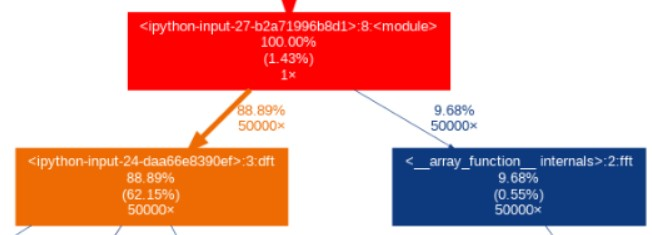




In [ ]:
!gprof2dot -f pstats dft_fft_profile_small.pstat | dot -Tpng -o output.png

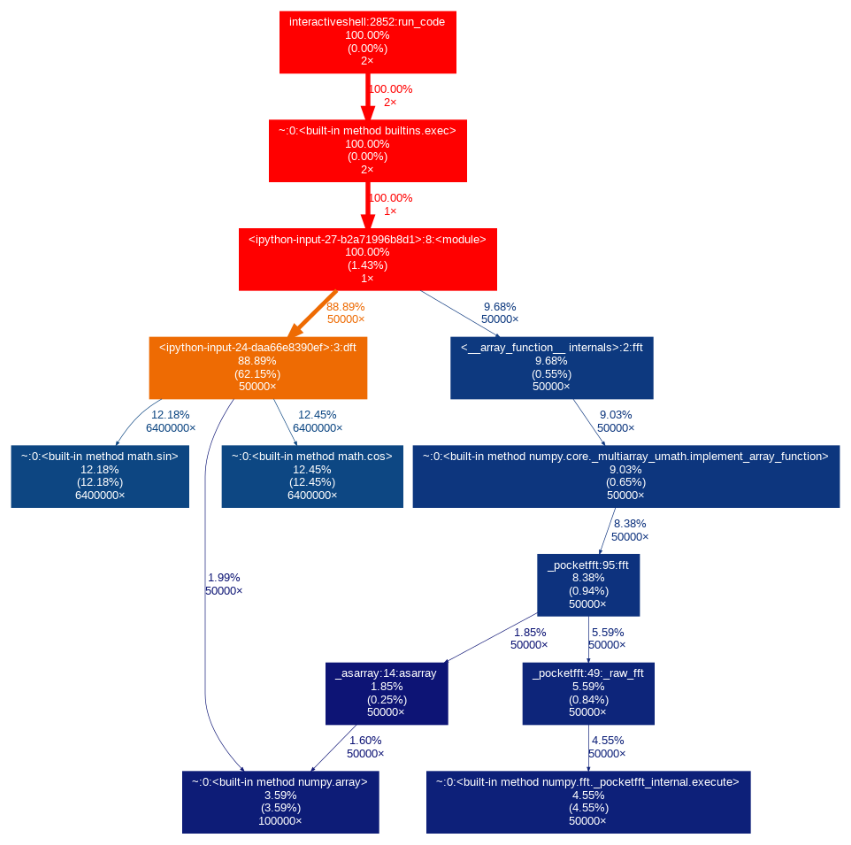

In [ ]:
import skimage.io
I = skimage.io.imread(r"/content/output.png")

plt.figure(figsize=(15,20))
plt.imshow(I)
plt.axis("off")
plt.show()